In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('white')
sns.set_context('talk', font_scale = 1)
import os

import math
from pytorch_pretrained_bert import BertTokenizer
os.chdir('../')
from modeling_readmission import BertForSequenceClassification
import modeling_readmission

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

in the modeling class


04/15/2021 14:45:06 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\ntaylor\.pytorch_pretrained_bert\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [4]:
bert_config = modeling_readmission.BertConfig.from_json_file('./model/discharge_readmission/bert_config.json')
model = BertForSequenceClassification(bert_config, num_labels = 1)

In [5]:
bert_config

{
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [6]:
bert_config.num_attention_heads

12

In [7]:
dicts=model.load_state_dict(torch.load('./model/discharge_readmission/pytorch_model.bin',map_location='cpu'))

In [8]:
dicts

<All keys matched successfully>

In [9]:
model.bert.encoder.layer[0].attention.self

BertSelfAttention(
  (query): Linear(in_features=768, out_features=768, bias=True)
  (key): Linear(in_features=768, out_features=768, bias=True)
  (value): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [10]:
def transpose_for_scores(config, x):
    new_x_shape = x.size()[:-1] + (config.num_attention_heads, int(config.hidden_size / config.num_attention_heads))
    x = x.view(*new_x_shape)
    return x.permute(0, 2, 1, 3)

In [11]:
def get_attention_scores(model,i,text):
    tokenized=tokenizer.tokenize(text)

    indexed_tokens=tokenizer.convert_tokens_to_ids(tokenized)

    segment_ids=[0]*len(indexed_tokens)
    t_tensor=torch.tensor([indexed_tokens])
    s_ids=torch.tensor([segment_ids])

    outputs_query= []
    outputs_key= []

    def hook_query(module, input, output):
        #print ('in query')
        outputs_query.append(output)

    def hook_key(module, input, output):
        #print ('in key')
        outputs_key.append(output)

    model.bert.encoder.layer[i].attention.self.query.register_forward_hook(hook_query)
    model.bert.encoder.layer[i].attention.self.key.register_forward_hook(hook_key)
    l=model(t_tensor,s_ids)
    
    query_layer = transpose_for_scores(bert_config,outputs_query[0])
    key_layer = transpose_for_scores(bert_config,outputs_key[0])
    
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
    attention_scores = attention_scores / math.sqrt(int(bert_config.hidden_size / bert_config.num_attention_heads))
    attention_probs = nn.Softmax(dim=-1)(attention_scores)
    
    return attention_probs,tokenized

In [14]:
text=' he has experienced acute on chronic diastolic heart failure in the setting of volume overload due to his sepsis.'
x,tokens=get_attention_scores(model,0,text)
print(x)
print(tokens)

tensor([[[[4.7076e-02, 3.9257e-02, 3.7232e-02,  ..., 2.5930e-02,
           1.6974e-02, 2.8806e-02],
          [8.3743e-02, 4.0392e-02, 4.0097e-02,  ..., 1.4374e-02,
           1.1751e-02, 1.7059e-02],
          [7.2749e-02, 6.1645e-02, 2.6183e-02,  ..., 2.7006e-02,
           1.3242e-02, 2.8258e-02],
          ...,
          [1.6053e-02, 3.1423e-02, 5.6450e-02,  ..., 1.8733e-02,
           4.9531e-02, 1.6498e-02],
          [4.6433e-02, 2.5764e-02, 5.9714e-02,  ..., 2.9297e-02,
           9.0346e-03, 2.1076e-02],
          [5.0005e-02, 2.8451e-02, 7.1000e-02,  ..., 1.9229e-02,
           1.4563e-02, 2.3947e-02]],

         [[1.7489e-01, 1.2389e-02, 1.7955e-02,  ..., 7.4784e-03,
           3.4807e-02, 9.2124e-03],
          [7.3951e-04, 1.5280e-02, 9.1026e-02,  ..., 2.4973e-02,
           9.4856e-02, 1.9937e-03],
          [2.7243e-03, 3.4107e-02, 1.3150e-02,  ..., 5.4836e-02,
           7.1407e-02, 4.6321e-03],
          ...,
          [2.5933e-02, 6.5655e-02, 2.7142e-02,  ..., 9.1164

In [15]:
map1=np.asarray(x[0][1].detach().numpy())
len(tokens)

24

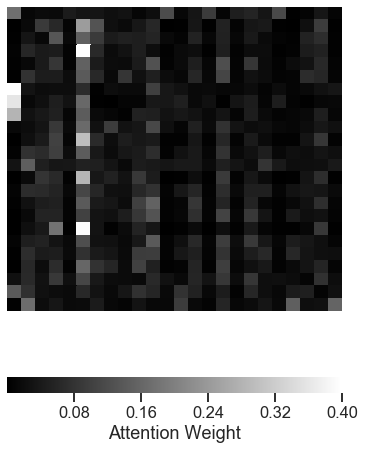

In [16]:
f, ax = plt.subplots(figsize=(6,8))
sns.heatmap(map1, annot=False, fmt="f", ax=ax, xticklabels = False, yticklabels = False, vmax=0.4, cmap='gray', cbar_kws={'label':'Attention Weight', 'orientation':'horizontal'}, rasterized = True)

<Figure size 432x288 with 0 Axes>

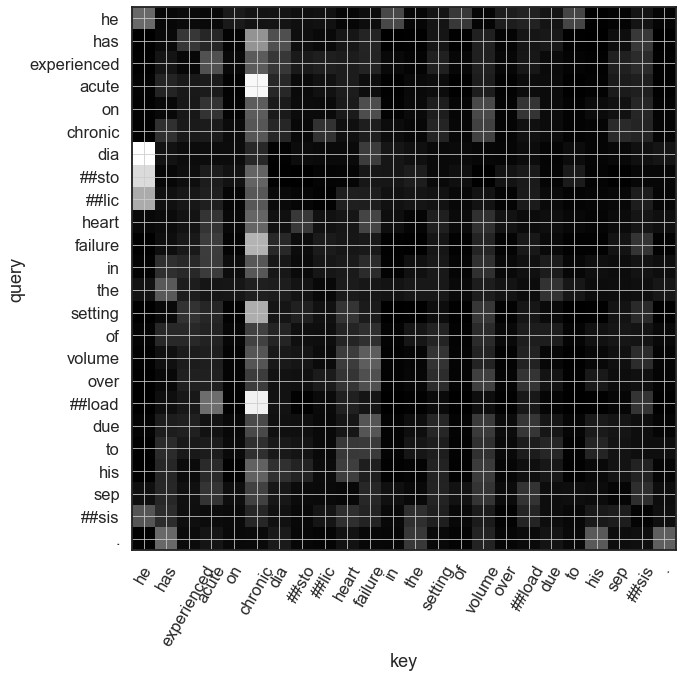

In [17]:
plt.clf()

f=plt.figure(figsize=(10,10))
ax = f.add_subplot(1,1,1)
i=ax.imshow(map1,interpolation='nearest',cmap='gray')

ax.set_yticks(range(len(tokens)))
ax.set_yticklabels(tokens)

ax.set_xticks(range(len(tokens)))
ax.set_xticklabels(tokens,rotation=60)

ax.set_xlabel('key')
ax.set_ylabel('query')

ax.grid(linewidth = 0.8)

In [ ]:
text = 'confidential notes from mimic iii'
x,tokens=get_attention_scores(model,0,text)
map1=np.asarray(x[0][1].detach().numpy())

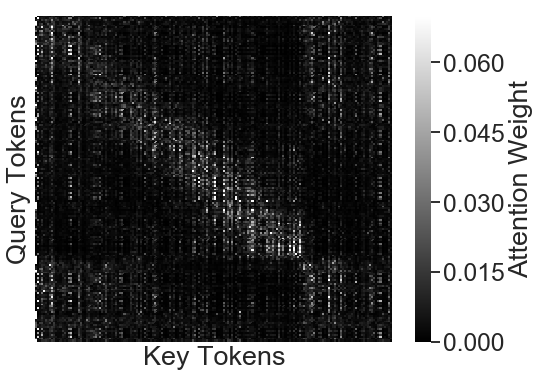

In [112]:
f, ax = plt.subplots(figsize=(8,6))
sns.heatmap(map1, annot=False, fmt="f", ax=ax, xticklabels = False, yticklabels = False, vmin=0, vmax=0.07, cmap='gray', cbar_kws={'label':'Attention Weight'})

ax.set_xlabel('Key Tokens')
ax.set_ylabel('Query Tokens')